In [0]:

import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

from keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random

from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
import numpy as np
import cv2

import gc



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    add,
    multiply
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


In [0]:
norms = np.array([0.4914, 0.4822, 0.4465])
stds = np.array([0.2023, 0.1994, 0.2010])

In [4]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))


170500096/170498071 [==============================] - 2s 0us/step


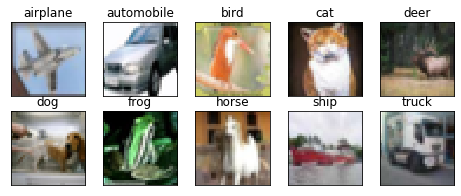

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def normalize_img(img):
  img = img/255
  img = img - norms
  img = img/stds
  return img

def pad_img(img):
  return np.pad(img, ((4,4),(4,4),(0,0)), mode='constant',)

def random_crop(x, random_crop_size):
    w, h = x.shape[0], x.shape[1]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1],:]


def get_random_eraser(p=0.5, s_l=0.05, s_h=0.5, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

cutout_fn = get_random_eraser(p=0.7, s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, pixel_level=True)
def reg_fn(x):
  x = pad_img(x)
  x = random_crop(x,[32,32])
  x = cutout_fn(x)
  return x




In [0]:
from keras.utils import np_utils
train_features = np.array(list(map(normalize_img,train_features)))
test_features = np.array(list(map(normalize_img,test_features)))



In [0]:
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Resnet Functions

In [0]:


class StopAtAccValue(Callback):
  def __init__(self,validation_iterator, threshold = 0.9, ):
    super(StopAtAccValue, self).__init__()
    self.threshold = threshold
    self.validation_iterator = validation_iterator
  def on_epoch_end(self, epoch, logs={}):
    score = self.model.evaluate_generator(self.validation_iterator,steps=len(self.validation_iterator))
    acc = score[1]
    if acc >= self.threshold:
      self.model.stop_training = True
      print("Stopping Training:: Val Acc = %.3f Achieved"%(acc))
    else:
      print("Continue Training:: Val Acc = %.3f, Threshold = %.3f"%(acc,self.threshold))
      

In [0]:
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow_probability as tfp
import tensorflow as tf
class custom_loss:
  
  def get_L2_enhanced_loss(model):
    conv_layers = [layer for layer in model.layers if type(layer)==Conv2D and layer.trainable_weights[0].shape.as_list()[0]>0]
    conv_layers = conv_layers[:-1]
    def L2_enhanced():
      total_loss = K.variable(0)
      for layer in conv_layers:
        weights = layer.trainable_weights[0]
        total_loss = total_loss + tf.nn.l2_loss(weights)
      return total_loss
    return L2_enhanced



  def get_combined_L2_cross_entropy_loss(model,alpha,batch_size,total_data_size,
                                        epochs, end_percentage=0.1, scale=100):
    l2_loss = custom_loss.get_L2_enhanced_loss(model, )
    iters_per_epoch = int(np.ceil(total_data_size/batch_size))
    num_iterations = epochs*iters_per_epoch
    mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
    container ={"iterations":0}
    sess = K.get_session()



    def combined_loss(y_true, y_pred):
      container['iterations'] = container['iterations'] + 1
      iterations = container['iterations']

      # new_alpha = lr_momentum_decider.min_max_scaler(iterations, num_iterations, end_percentage, alpha/scale, alpha, invert = False)

      new_alpha = alpha

      loss = categorical_crossentropy(y_true, y_pred) + new_alpha * l2_loss()
      return loss
    return combined_loss

In [0]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D
from tensorflow.keras.initializers import zeros


def ResConv(x, kernel=(3, 3), depth=32, maxpool=False,lastresnet=False):
    x = BatchNormalization()(x)
    
    if maxpool :
        x = MaxPool2D()(x)
    x = Conv2D(depth, kernel, padding='same', use_bias=False)(x)
    if not lastresnet :
      x = Activation('relu')(x)
      
    return x

def ResUnit(x, depth=32, maxpool=False):
    x = ResConv(x, depth=depth, maxpool=maxpool)
    x = ResConv(x, depth=depth,lastresnet=True)
    return x
    
def ResNetBlock(x, nunit, depth=32, maxpool=False, name="Block-1"):
    assert nunit > 0, "Ensure there are at least 1 unit in the ResNet Block"
    nunit -= 1
    if maxpool:
        xskip = Conv2D(depth, (1, 1), strides=2, use_bias=False)(x)
        xskip = BatchNormalization()(xskip)
    else: 
        xskip = x
        xskip = BatchNormalization()(xskip)
    x = add([ResUnit(x, depth=depth, maxpool=maxpool), xskip])
    x = Activation('relu')(x)
    if nunit >= 1:
        nunit -= 1
        for i in range(nunit):
            x = add([ResUnit(x, depth=depth), x])
            x = Activation('relu')(x)
        x = add([ResUnit(x, depth=depth), x], name=name)
        
    return x
        
def ResNet18(x):
    x = Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(x)
    
    
    nunits   = (2, 2, 2, 2)
    maxpools = (False, True, True, True)
    depths   = (64, 128, 256, 512)
    
    for i in range(4):
        x = ResNetBlock(x, nunits[i], depth=depths[i], maxpool=maxpools[i], name="Block-"+str(i))
    x = GlobalAvgPool2D()(x)
    return x

In [0]:
BATCH_SIZE = 128
WT_DECAY   = 5e-4
LRFNEPOCH  = 4
MOMENTUM   = 0.9
EPOCHS     = 300
LEARNING_RATE = 0.01

batch_size = 128
alpha = 5e-4
epochs = 100
cutout_proba = 0.25
max_erasures_per_image = 1
end_percentage = 0.05

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
def model_init(optimizer=None):
    xin = Input(shape=(32, 32, 3), name="Input")
    x = ResNet18(xin)
    x = Dense(num_classes, use_bias=False)(x)
    y = Activation('softmax')(x)
    model = Model(xin, y)
    
    if optimizer is None:
        optimizer = SGD(lr=0.01, momentum=MOMENTUM, nesterov=True,decay=5e-4)
    model.compile(loss=custom_loss.get_combined_L2_cross_entropy_loss(model,alpha,128,train_features.shape[0], epochs=100, end_percentage=end_percentage),
               optimizer=optimizer,
               metrics=['accuracy'])
    print("Model Params = ",model.count_params(), ", Metric Names = ",model.metrics_names)
    return model

model = model_init()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model Params =  11181760 , Metric Names =  ['loss', 'acc']
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   

In [0]:
class CyclicLR(Callback):
   

    def __init__(self, base_lr=0.001, max_lr=0.05, step_size=2000., mode='exp_range',
                 scale_fn=None, scale_mode='cycle'):
				 
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        
        if scale_fn == None:
            
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            print(' The learning rate used was ', self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())   
            print(' The learning rate used was ', self.clr())
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        #print(' The learning rate used was ', self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(" - lr: %0.5f " % (self.history['lr'][-1]))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             preprocessing_function=reg_fn)

datagen.fit(train_features)

In [18]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(test_features)
checkpoint = ModelCheckpoint("model_clr.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(train_features, train_labels, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(test_features, test_labels, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

cl = CyclicLR()
callbacks=[cl,checkpoint,stopper]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=1,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")

 The learning rate used was  0.001
Epoch 1/100
 79/391 [=====>........................] - ETA: 23s - loss: 4.7209 - acc: 0.1997 - lr: 0.01056 
Continue Training:: Val Acc = 0.200, Threshold = 0.900
391/391 [==============================] - 108s 277ms/step - loss: 2.7280 - acc: 0.3301 - val_loss: 4.7209 - val_acc: 0.1997
Epoch 2/100
 78/391 [====>.........................] - ETA: 21s - loss: 3.0154 - acc: 0.3830 - lr: 0.02013 
Continue Training:: Val Acc = 0.383, Threshold = 0.900
391/391 [==============================] - 96s 247ms/step - loss: 2.2628 - acc: 0.5057 - val_loss: 3.0220 - val_acc: 0.3829
Epoch 3/100
 78/391 [====>.........................] - ETA: 20s - loss: 1.9508 - acc: 0.6350 - lr: 0.02971 
Continue Training:: Val Acc = 0.635, Threshold = 0.900
391/391 [==============================] - 96s 246ms/step - loss: 1.9622 - acc: 0.6089 - val_loss: 1.9466 - val_acc: 0.6353
Epoch 4/100
 78/391 [====>.........................] - ETA: 20s - loss: 1.6497 - acc: 0.7125 - lr: 0.03

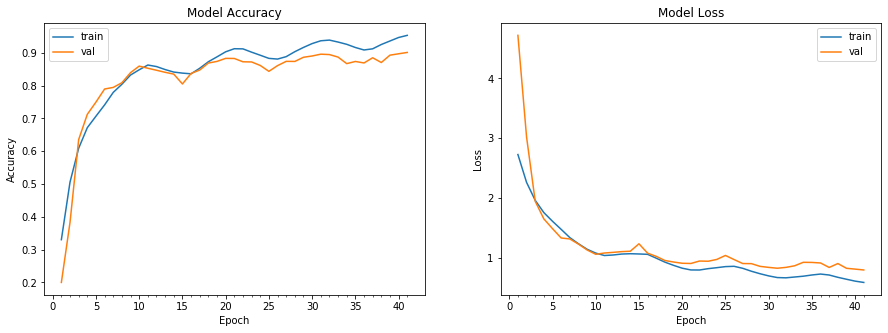

Accuracy on test data is: 90.10


In [19]:
plot_model_history(train_history)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))